In [1]:
# !pip install -q pandas
# pip install -q matplotlib
# !pip install -q scikit-learn

# Qini-кривая и оценка качества офлайн

## Шаг 1: Сбор данных

Предположим, у вас есть данные для 100 пользователей:
- 50 пользователей получили рекламное предложение (группа воздействия).
- 50 пользователей не получили предложение (контрольная группа).

In [2]:
import pandas as pd
import numpy as np

# генерация данных для 100 пользователей
np.random.seed(42)
n = 100
treatment = np.array([1]*50 + [0]*50)
outcome = np.concatenate([np.random.choice([1, 0], p=[0.2, 0.8], size=50),
                          np.random.choice([1, 0], p=[0.1, 0.9], size=50)])
uplift_prediction = np.random.rand(n)

# создание DataFrame
data = {
    'user_id': range(1, n+1),
    'treatment': treatment,  # получение рекламных предложений
    'outcome': outcome,      # полученная реакция
    'uplift_prediction': uplift_prediction
}

df = pd.DataFrame(data)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0        1          1        0           0.031429
1        2          1        0           0.636410
2        3          1        0           0.314356
3        4          1        0           0.508571
4        5          1        1           0.907566


In [9]:
np.random.choice([1, 0], p=[0.2, 0.8], size=50).sum()

np.int64(11)

In [10]:
np.random.choice([1, 0], p=[0.1, 0.9], size=50).sum()

np.int64(6)

## Шаг 2: Сортировка данных по uplift_prediction

In [4]:
# сортировка данных по uplift_prediction
df = (
    df.sort_values(by='uplift_prediction', ascending=False)
    .reset_index(drop=True)
)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0       55          0        0           0.985650
1       40          1        0           0.971782
2       41          1        1           0.962447
3       35          1        0           0.942910
4       79          0        0           0.936730


## Шаг 3: Инициализация переменных для расчёта CGain и Random

In [5]:
# инициализация переменных
nt = 0   # число точек, на которых было воздействие до заданной точки
nt_1 = 0 # число точек, на которых были воздействия и реакция пользователя
nc = 0   # число точек, на которых не было воздействие до заданной точки (c — control). 
nc_1 = 0 # число точек, на которых не было воздействия и реакции пользователя.
cgain = [] # точка Qini-кривой, рассчитанная на заданном объекте выборк
random = [] # результат применения случайной модели
optimum = [] # максимальное значение uplift, которое мы можем получить на выборке.
incremental_purchases = 0 # добавленные покупки
opt_incremental_purchases = df['outcome'].sum() # максимально добавленные покупки

In [7]:
opt_incremental_purchases

np.int64(22)

## Шаг 4: Расчёт CGain, Random и Optimum

In [6]:
# расчёт CGain, Random и Optimum
for i, row in df.iterrows():
    if row['treatment'] == 1:
        nt += 1
        if row['outcome'] == 1:
            nt_1 += 1
            incremental_purchases += 1
    else:
        nc += 1
        if row['outcome'] == 1:
            nc_1 += 1

    cgain.append(incremental_purchases)
    random.append(opt_incremental_purchases * (i + 1) / len(df))
    optimum.append(min(opt_incremental_purchases, (i + 1) * 1.0))

## Шаг 5: Расчёт метрик

In [11]:
from sklearn.metrics import auc

# расчёт площади под кривыми
qini_auc = auc(range(1, len(cgain) + 1), cgain)
random_auc = auc(range(1, len(random) + 1), random)

# расчёт Qini Score
qini_score = qini_auc - random_auc

# вывод Qini Score
print(f'Qini Score: {qini_score}') 

Qini Score: -264.3900000000001


## Шаг 6: Построение графика

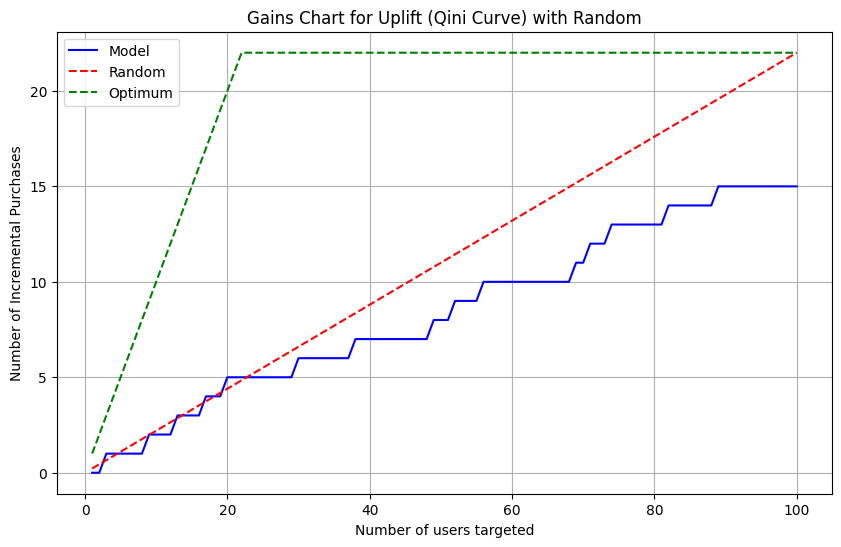

In [12]:
import matplotlib.pyplot as plt

# построение графиков
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cgain) + 1), cgain, label='Model', color='blue')
plt.plot(range(1, len(random) + 1), random, label='Random', color='red', linestyle='--')
plt.plot(range(1, len(optimum) + 1), optimum, label='Optimum', color='green', linestyle='--')
plt.xlabel('Number of users targeted')
plt.ylabel('Number of Incremental Purchases')
plt.title('Gains Chart for Uplift (Qini Curve) with Random')
plt.legend()
plt.grid(True)
plt.show()

## Задание

Ниже приведён код для отрисовки Qini-кривой. Дополните его и посчитайте Qini Score (площадь под кривой). 

Данные можете взять отсюда: `https://storage.yandexcloud.net/mle-data/sprint-5/discountuplift.csv`.

В данном датасете нас интересуют 2 колонки: `uplift_score` и `target_class`.

Расшифровка `target_class`:

- `0` — контрольная выборка, не купили товар ($y_c=0$, в наших терминах)
- `1` — контрольная выборка, купили товар ($y_c=1$, в наших терминах)
- `2` — выборка с воздействием (скидка), не купили товар ($y_t=0$, в наших терминах);
- `3` — выборка с воздействием (скидка), купили товар ($y_t=1$, в наших терминах).


In [13]:
# !mkdir datasets
# !wget https://storage.yandexcloud.net/mle-data/sprint-5/discountuplift.csv
# !mv discountuplift.csv datasets

In [20]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# загружаем DataFrame
discount = pd.read_csv("datasets/discountuplift.csv", sep="\t")
discount.sample(3, random_state=42)

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
9948,1,186.66,0,1,1,1,1,0,0,0,0,1,0.417925,0.166987,0.279740,0.135348,0.081161,2
2002,8,508.14,1,1,1,1,0,1,0,0,1,0,0.528632,0.061418,0.308849,0.101101,0.285057,2
3045,9,286.62,0,1,1,1,0,0,1,0,0,1,0.567822,0.022656,0.348541,0.060981,0.221080,2


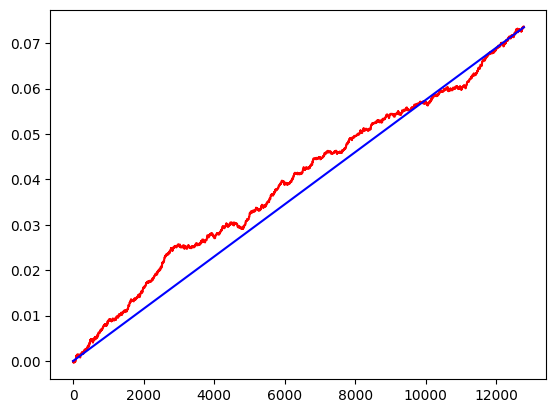

np.float64(33.22356)

In [70]:
# реализуем подсчёт Qini Score:
def qini_df(df):
    # 1. Отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values(by='uplift_score', ascending=False).reset_index(drop=True) # Ваш код здесь
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = ranked['n_t1/nt'] - ranked['n_c1/nc'] # Ваш код здесь
    # добавим случайную кривую
    end_point = ranked['uplift'].tail(1).values[0]
    ranked['random_uplift'] = np.linspace(0, end_point, ranked.shape[0]) # Ваш код здесь
    ranked["n"] = np.arange(ranked.shape[0]) # Ваш код здесь
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini_df(discount).round(5)

Это значит, что ваша модель лучше модели случайного воздействия (Qini Score положительный) — Baseline для других моделей создан. 

Итак, вы разобрались, как оценивать офлайн-качество uplift-моделей по их предсказанию. Дальше мы расскажем о том, как собрать выборку для правильной оценки качества, а также о том, как проводить A/B-тесты онлайн в случае uplift-моделирования.

# A/B-тесты и оценка качества онлайн
(Пример проведения A/B-теста для uplift-моделирования)

## Шаг 1: Определение цели и параметров теста
Предположим, что цель теста — увеличить количество поездок в сервисе такси после выдачи скидок.

- Цель: увеличение количества поездок.
- Метрики: количество поездок, средний чек, общий доход.
- Период: две недели.

## Шаг 2: Разделение аудитории
Аудитория делится на две группы случайным образом.

- Контрольная группа: не получает скидки.
- Экспериментальная группа: получает скидки.

In [3]:
import pandas as pd
import numpy as np

# загрузим данные пользователей
data = pd.read_csv(FILENAME)

# добавим колонку с группой (контрольная или экспериментальная)
np.random.seed(42)  # для воспроизводимости результатов
data['group'] = np.random.choice(['control', 'experiment'], size=len(data))

# сохраним контрольную и экспериментальную группы в отдельные переменные
control_group = data[data['group'] == 'control']
experiment_group = data[data['group'] == 'experiment']

## Шаг 3: Предоставление версий элемента
- Контрольная группа: видит стандартные цены без скидок.
- Экспериментальная группа: видит скидки на поездки.

In [5]:
# добавим колонку с информацией о скидках
data['discount'] = np.where(data['group'] == 'experiment', True, False)

# проверим результат
print(data.head())

## Шаг 4: Сбор данных

Собираются данные о количестве поездок, их стоимости, а также другие релевантные метрики в обеих группах.

In [ ]:
# создадим DataFrame для хранения результатов теста
results = pd.DataFrame(columns=['user_id', 'group', 'num_rides', 'total_spent'])

# симуляция данных для каждой группы
# для простоты примера мы используем случайные данные
for _, row in data.iterrows():
    num_rides = np.random.poisson(lam=5 if row['discount'] else 3)  # предполагаем, что скидки увеличивают среднее количество поездок
    total_spent = num_rides * (20 if row['discount'] else 25)  # допустим, что средняя стоимость поездки отличается
    
    results = results.append({
        'user_id': row['user_id'],
        'group': row['group'],
        'num_rides': num_rides,
        'total_spent': total_spent
    }, ignore_index=True)

# сохраним результаты
results.to_csv('ab_test_results.csv', index=False)

## Шаг 5: Анализ данных и интерпретация результатов

После завершения теста анализируются собранные данные:
- сравниваются результаты контрольной и экспериментальной групп;
- оценивается, насколько значимо увеличилось количество поездок в экспериментальной группе;
- применяются статистические тесты для определения значимости различий.


In [ ]:
from scipy import stats

# загрузим результаты теста
results = pd.read_csv('ab_test_results.csv')

# группируем данные
grouped_results = results.groupby('group').agg({
  'num_rides': ['mean', 'std', 'count'],
  'total_spent': ['mean', 'std', 'count']
})

print(grouped_results)

# сравниваем средние значения количества поездок
control_rides = results[results['group'] == 'control']['num_rides']
experiment_rides = results[results['group'] == 'experiment']['num_rides']

t_stat, p_value = stats.ttest_ind(control_rides, experiment_rides)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# оцениваем, насколько значимо увеличилось количество поездок в экспериментальной группе
if p_value < 0.05:
  print("Различие в количестве поездок между контрольной и экспериментальной группами статистически значимо.")
else:
  print("Различие в количестве поездок между контрольной и экспериментальной группами не является статистически значимым.")

Этот пример показывает ключевые этапы проведения A/B-теста для uplift-моделирования.
Сам же процесс помогает оценить эффективность маркетинговых воздействий и использовать полученные данные для обучения uplift-моделей.

# S-learner

Ваша задача — научиться выдавать скидки так, чтобы повысить вероятность покупки товара. 

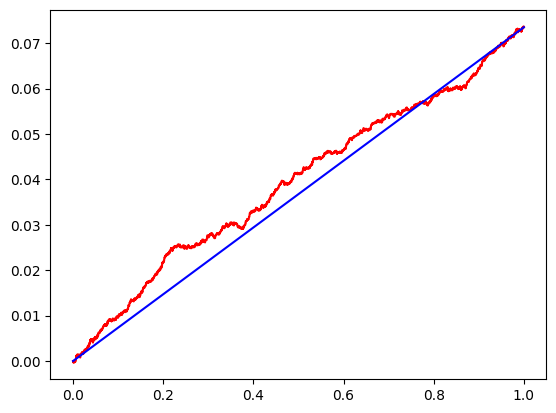

np.float64(33.18176)

In [10]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("datasets/discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания 
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini_df(df)

## Задание 1 из 4

Первое, что нужно сделать, — явно выделить колонки с целевой переменной, факторами и целевым воздействием. Напомним значения целевой переменной: 
- `0` — контрольная выборка, не купили товар ($y_c=0$);
- `1` — контрольная выборка, купили товар ($y_c=1$);
- `2` — выборка с воздействием (скидка), не купили товар ($y_t=0$);
- `3` — выборка с воздействием (скидка), купили товар ($y_t=1$).

Преобразуйте исходный датафрейм:
- добавьте колонку `old_target` — колонка, которая принимает значение 1, если была покупка, и 0 в противном случае;
- выделим колонки с факторами и колонку с фактом «целевого воздействия» — выдачи скидки.

In [34]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("datasets/discountuplift.csv", sep="\t")

In [35]:
# ваш код здесь (таргет — факт покупки)
df['old_target'] = 0
df.loc[df.target_class.isin([1, 3]),'old_target'] = 1

In [36]:
feature_cols = [
    'recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
    'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
    'channel_Multichannel', 'channel_Phone', 'channel_Web'
]

In [37]:
target_col = 'old_target' # имя колонки с целевой переменной
treatment_col = 'treatment'

In [38]:
df[df[target_col] == 1].shape[0]

1878

## Задание 2 из 4

Теперь разбейте выборку на тренировочную и тестовую.
Условия: `random_state=1`, размер тестовой выборки — 25%, разбиение стратифицированное по колонке с фактом целевого воздействия и с целевой переменной.

In [39]:
from sklearn.model_selection import train_test_split

# разбейте выборку на тренировочную и тестовую
df_train, df_test = train_test_split(
    df, stratify=df.old_target, test_size=0.25, random_state=1
)

In [40]:
df_train.shape, df_test.shape

((9588, 19), (3196, 19))

In [41]:
# Чему равна доля значений 1 в целевой переменной из тренировочного датасета? 
round(df_train.value_counts(target_col, normalize=True), 5)

old_target
0    0.85305
1    0.14695
Name: proportion, dtype: float64

In [42]:
0.14695

0.14695

## Задание 3 из 4

Теперь обучите S-learner (в данном случае это логистическая регрессия).

In [43]:
from sklearn.linear_model import LogisticRegression

# создайте логистическую регрессию с random_state=1
s_learner = LogisticRegression(random_state=1)
s_learner.fit(
    X=df_train[feature_cols + [treatment_col]],
    y=df_train[target_col]
)

# посчитайте intercept
s_learner.intercept_

array([-1.40435315])

In [44]:
# Чему равен intercept в обученной модели? Ответ округлите до пятого знака после запятой.
round(s_learner.intercept_[0], 5)

np.float64(-1.40435)

## Задание 4 из 4

Измерьте качество модели при помощи Qini Score. В прекоде к этому заданию мы затронем все шаги — в будущем же вы сможете писать более короткий код инференса модели. 

In [45]:
# предскажем вероятность покупки, если скидка есть
df_test[treatment_col] = 1
df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

# предскажите вероятность покупки, если скидки нет 
df_test[treatment_col] = 0
df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1] # ваш код здесь

# посчитаем uplift на объектах тестовой выборки
uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals 

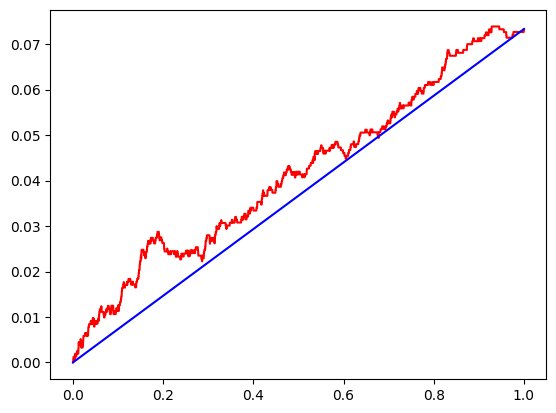

np.float64(15.692)

In [49]:
# посчитаем Qini Score по нашему датасету 
ranked = df_test.sort_values("uplift_score", ascending=False)

N_c = sum(ranked['target_class'] <= 1)
N_t = sum(ranked['target_class'] >= 2)

# посчитаем в отсортированном датафрейме основные показатели, 
# которые используются при расчёте Qini Score
ranked['n_c1'] = 0
ranked['n_t1'] = 0
ranked.loc[ranked.target_class == 1,'n_c1'] = 1
ranked.loc[ranked.target_class == 3,'n_t1'] = 1
ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t

# посчитаем Qini-кривую и случайную прямую под ней
ranked['uplift'] = ranked['n_t1/nt'] - ranked['n_c1/nc']
# добавим случайную кривую
ranked['random_uplift'] = ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1]

ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
# немного кода для визуализации
plt.plot(ranked['n'], ranked['uplift'], color='r')
plt.plot(ranked['n'], ranked['random_uplift'], color='b')
plt.show()

round((ranked['uplift'] - ranked['random_uplift']).sum(), 5)

# T-learner

## Задание 1 из 2
Обучите две логистические регрессии для нашего T-learner. 

In [78]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("datasets/discountuplift.csv", sep="\t")

In [79]:
df['old_target'] = (df['target_class'] % 2).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

In [80]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25
)

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
# создайте логистическую регрессию с random_state=1
t_learner_1 = LogisticRegression(verbose=0, random_state=1)

# создайте логистическую регрессию с random_state=1
t_learner_0 = LogisticRegression(verbose=0, random_state=1)

In [ ]:
# обучите модели

In [93]:
# t_learner_1 — модель, обученная на выборке с воздействием
t_learner_1.fit(
    X=df_train[df_train.target_class.isin([2,3])][feature_cols + [treatment_col]],
    y=df_train[df_train.target_class.isin([2,3])][target_col]
)

# посчитайте intercept
t_learner_1.intercept_.round(5)

array([-0.67476])

In [92]:
# t_learner_0 — модель, обученная на выборке без воздействия
t_learner_0.fit(
    X=df_train[df_train.target_class.isin([0,1])][feature_cols + [treatment_col]],
    y=df_train[df_train.target_class.isin([0,1])][target_col]
)

# посчитайте intercept
t_learner_0.intercept_.round(5)

array([-1.24992])

## Задание 2 из 2
А теперь измерьте качество того, что получилось. 

In [101]:
# ваш код применения t_learner_1
df_test['yes_treatment'] = t_learner_1.predict_proba(
    df_test[feature_cols+[treatment_col]]
)[:,1]

# ваш код применения t_learner_0
df_test['no_treatment'] = t_learner_0.predict_proba(
    df_test[feature_cols+[treatment_col]]
)[:,1]

In [102]:
# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

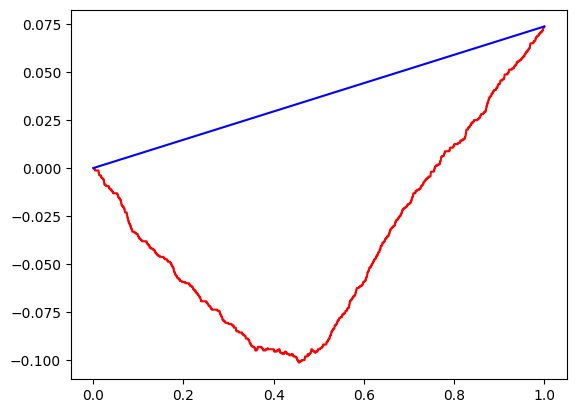

np.float64(-230.6112)

In [104]:
uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
df_test['uplift_score'] = uplift_vals
qini_df(df_test).round(4)

# Реализация подходов с помощью библиотеки Causal ML

In [3]:
# !pip install -q causalml

Сейчас вас интересуют BaseSClassifier, BaseTClassifier — это метаалгоритмы, реализующие логику, которую до этого вы писали руками. Вам нужно переписать применение алгоритмов, над которыми вы так кропотливо работали ранее.

In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("datasets/discountuplift.csv", sep="\t")

In [2]:
df['old_target'] = (df['target_class'] % 2).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25
)

## Задание 1 из 2

Начнём с обучения S-learner на основе логистической регрессии. С помощью библиотеки Causal ML настройте автоматизацию обучения, которое ранее вы осуществляли вручную.

In [8]:
from causalml.inference.meta import BaseSClassifier
from sklearn.linear_model import LogisticRegression

s_learner = BaseSClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))

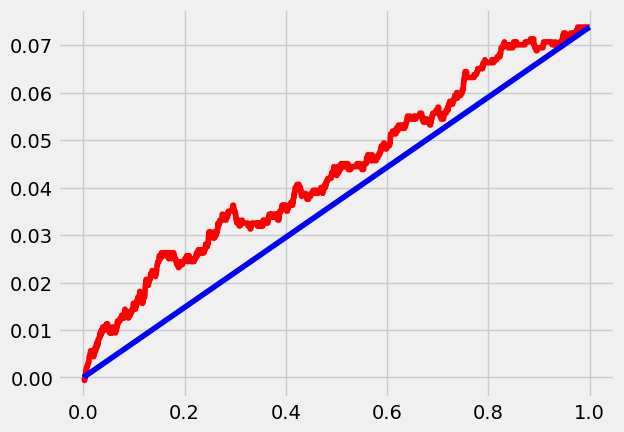

20.99312

In [10]:
# оцените качество
df_test['uplift_score'] = uplift_vals 
# посчитаем Qini Score по нашему датасету 
ranked = df_test.sort_values("uplift_score", ascending=False)

N_c = sum(ranked['target_class'] <= 1)
N_t = sum(ranked['target_class'] >= 2)

# посчитаем в отсортированном датафрейме основные показатели, 
# которые используются при расчёте Qini Score
ranked['n_c1'] = 0
ranked['n_t1'] = 0
ranked.loc[ranked.target_class == 1,'n_c1'] = 1
ranked.loc[ranked.target_class == 3,'n_t1'] = 1
ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t

# посчитаем Qini-кривую и случайную прямую под ней
ranked['uplift'] = ranked['n_t1/nt'] - ranked['n_c1/nc']
# добавим случайную кривую
ranked['random_uplift'] = ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1]

ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
# немного кода для визуализации
plt.plot(ranked['n'], ranked['uplift'], color='r')
plt.plot(ranked['n'], ranked['random_uplift'], color='b')
plt.show()

round((ranked['uplift'] - ranked['random_uplift']).sum(), 5)

Суть ясна, но снова возникает вопрос: почему значение качества поменялось? Все несоответствия возникают потому, что используются другие форматы данных. Простое объяснение: это внутренние процессы causalml, например прямая конвертация в numpy.array с маскированием treatment-эффекта. Детали: https://causalml.readthedocs.io/en/latest/_modules/causalml/inference/meta/slearner.html

## Задание 2 из 2
Теперь обучите T-learner, используя Causal ML, и оцените его качество.

In [4]:
from causalml.inference.meta import BaseTClassifier
from sklearn.linear_model import LogisticRegression

t_learner = BaseTClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))

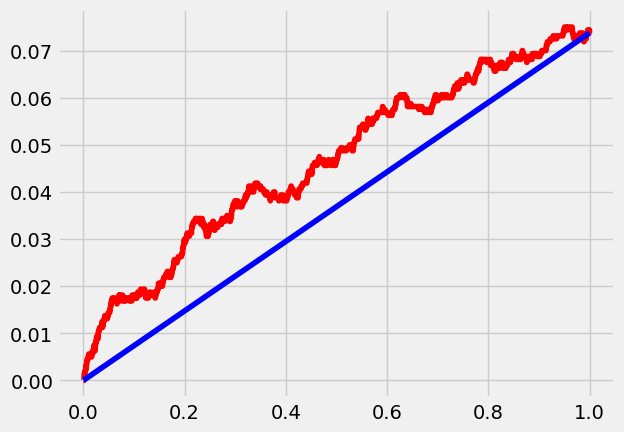

30.78098

In [5]:
# оцените качество
df_test['uplift_score'] = uplift_vals 
# посчитаем Qini Score по нашему датасету 
ranked = df_test.sort_values("uplift_score", ascending=False)

N_c = sum(ranked['target_class'] <= 1)
N_t = sum(ranked['target_class'] >= 2)

# посчитаем в отсортированном датафрейме основные показатели, 
# которые используются при расчёте Qini Score
ranked['n_c1'] = 0
ranked['n_t1'] = 0
ranked.loc[ranked.target_class == 1,'n_c1'] = 1
ranked.loc[ranked.target_class == 3,'n_t1'] = 1
ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t

# посчитаем Qini-кривую и случайную прямую под ней
ranked['uplift'] = ranked['n_t1/nt'] - ranked['n_c1/nc']
# добавим случайную кривую
ranked['random_uplift'] = ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1]

ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
# немного кода для визуализации
plt.plot(ranked['n'], ranked['uplift'], color='r')
plt.plot(ranked['n'], ranked['random_uplift'], color='b')
plt.show()

round((ranked['uplift'] - ranked['random_uplift']).sum(), 5)

Какие выводы можно сделать? Да, числа не совпадают с предыдущими результатами: не существует строгих статистических критериев, которые бы определяли, какая модель будет лучше, — это делают эксперименты.

# X-learner

В X-learner обучаются четыре модели: две на исходных данных и две, предсказывающие uplift эффект. Иногда обучается отдельная модель для оценки склонности.

Требуется применить модель два раза — с двумя разными моделями, оценивающими uplift-эффект.

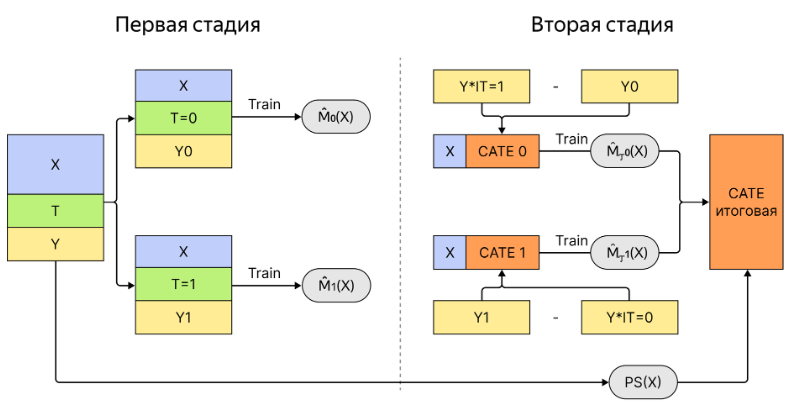

**Первая стадия:**
- Обучающую выборку, состоящую из всех объектов, разбиваем на две выборки: на тех, кто получали воздействие (скидку), и тех, кто нет.
- На каждой выборке учим свою модель и запоминаем, какая из моделей на какой выборке обучается.
- Вычисляем новую целевую переменную:
  - для контрольной группы — это разница между предсказанием модели, обученной на экспериментальной группе, и фактическим результатом;
  - для экспериментальной группы — это разница между фактическим результатом и предсказанием модели отклика, обученной на контрольной группе.
- Таким образом, новая целевая переменная — это uplift, как если бы воздействия не было там, где оно было, и было бы там, где его не было.
- Учим модели на новые целевые переменные: первая модель предсказывать uplift на контрольной группе, если на неё повоздействовать, а вторая — если этого не делать.

**Вторая стадия:**
- Для каждого объекта применяем модель $\hat{M}_{\tau0}(X)$, предсказывающую uplift, если объект попадает в контрольную группу.
- Для каждого объекта применяем модель $\hat{M}_{\tau1}(X)$, предсказывающую uplift, если объект попадает в экспериментальную группу.
- Итоговый uplift — взвешенное предсказание двух моделей.

Данный подход помогает эффективно работать с несбалансированными данными, так как модели обучаются на оценках uplift-эффекта для «противоположных» групп. Это позволяет X-learner более точно распознавать и предсказывать эффект воздействия, даже когда данные не сбалансированы. 

In [49]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
discount = pd.read_csv("datasets/discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()
 
discount['old_target'] = (discount['target_class'] % 2 == 0).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

# разобъём нашу выборку на тестовую и валидационную

df_train, df_test = train_test_split(discount, stratify=discount[[treatment_col, target_col]], random_state=1, test_size=0.25)
df_train.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
309,10,95.49,0,1,1,1,1,0,0,0,0,1,0.385971,0.033124,0.501814,0.079090,0.114224,2,1
5927,6,293.78,1,1,1,0,0,1,0,0,0,1,0.522508,0.060261,0.311440,0.105791,0.300301,1,0
8778,6,29.99,0,1,1,0,0,1,0,0,0,1,0.453994,0.041645,0.437831,0.066529,0.095770,0,1
11331,5,467.42,1,1,0,0,0,0,1,0,1,0,0.405045,0.134821,0.225336,0.234798,0.521099,0,1
4924,2,326.64,1,0,0,1,0,0,1,0,1,0,0.514283,0.047125,0.370299,0.068294,0.143541,3,0


## Задание

Постройте X-learner для решения задачи классификации.
Для этого импортируйте X-learner из библиотеки Causal ML, а именно из
`causalml.inference.meta`.
X-learner доступен как класс `BaseXClassifier`.

In [50]:
from causalml.inference.meta import BaseXClassifier # импортируйте необходимый класс из causalml (базовый классификатор)
from sklearn.linear_model import LogisticRegression, LinearRegression

# создадим базовый X-learner:
# создайте классификатор с логистической регрессией,
# указав outcome_learner=LogisticRegression(random_state=13)
# и линейной регрессией для uplift-классификатора
# указав effect_learner=LinearRegression()
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(random_state=13),
    effect_learner=LinearRegression()
)

# для обучения нужны датафрейм с факторами и колонка с фактом воздействия
x_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

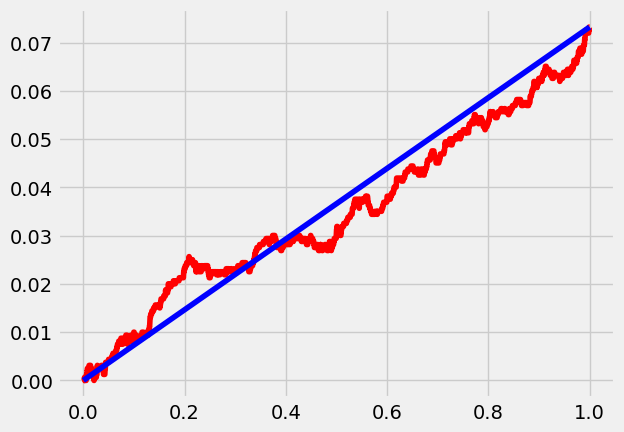

-5.310669999999999

In [51]:
# оцените Qini Score для обученного классификатора на тестовой выборке
qini_df(df_test)

Качество новой модели, возможно, ухудшилось — алгоритмы из предыдущей темы сработали лучше. В данном случае причина кроется в размере выборки. Мы получаем несмещённую оценку с нашим X-learner, но это требует большего объёма данных. В реальной практике часто ограничиваются тем, что используют базовые подходы, но про X-learner забывать нельзя, особенно если вы работаете в научной индустрии, такой как биотехнологии и т. д.

# R-Learner 

R-Learner — это подход к uplift-моделированию и анализу причинно-следственных связей. Он решает ту же задачу uplift-моделирования, что и разобранные ранее подходы, но в отличие от них пытается предсказать uplift-эффект одной моделью, которая строится поверх частных n моделей.

R-learner решает те же проблемы, что и X-learner, но делает это, вводя особую функцию потерь, с которой вы познакомитесь далее.

В R-lerner обучается n моделей/алгоритмов (out-of-fold) — их число определяется путём экспериментов.

**Шаг 1**

Обучим несколько частных моделей — таких, которые учатся на части семплов и делают предсказания на оставшихся. С помощью этого разбиения можно получить разные частные модели, каждая из которых «видела» только часть данных. Затем сделаем предсказания для e(x)
e(x) и m(x), где:
- e(x) — это вероятность объекта попасть под целевое воздействие. В простейшем случае — это доля объектов с целевым воздействием или доля объектов в А/B-тесте. Та же самая оценка склонности, которую мы разбирали ранее.
$$e^∗(x)=pr(T=1∣X=x)$$
- m(x) — среднее значение целевой переменной на объекте выборки.
$$m^∗(x)=E(Y∣X=x)=μ_{(0)}+e^∗(X_i)τ^∗(X_i)$$

То есть средний результат на объекте — это предсказание без дополнительного воздействия + вероятность дополнительного воздействия на объект, помноженный на эффект от воздействия.

Теперь для каждого объекта есть средние значения целевой переменной и оценка склонности.

Uplift-эффект в таком случае равен таргету — среднему воздействию:

$$Y_i - m^∗(X_i) = [T_i - e^∗(X_i)]τ^∗(X_i)+ϵ_i$$
 
У нас получилась оценка uplift и его аппроксимация функцией (моделью машинного обучения). Как её оптимизировать, чтобы получить наиболее точные предсказания? Например, с помощью среднеквадратической ошибки (MSE), что и будет функцией потерь.

**Шаг 2**

Обучим саму uplift-модель на функцию потерь MSE:

$$L_n(τ(x)) = \frac{1}{n} \sum_{i=1}^{n}{((Y_i-m^{-i}(X_i)) - (T_i - e^{-i}(X_i))τ(X_i)^2}$$

In [52]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
discount = pd.read_csv("datasets/discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()
 
discount['old_target'] = (discount['target_class'] % 2 == 0).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

# разобъём нашу выборку на тестовую и валидационную

df_train, df_test = train_test_split(discount, stratify=discount[[treatment_col, target_col]], random_state=1, test_size=0.25)
df_train.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
309,10,95.49,0,1,1,1,1,0,0,0,0,1,0.385971,0.033124,0.501814,0.079090,0.114224,2,1
5927,6,293.78,1,1,1,0,0,1,0,0,0,1,0.522508,0.060261,0.311440,0.105791,0.300301,1,0
8778,6,29.99,0,1,1,0,0,1,0,0,0,1,0.453994,0.041645,0.437831,0.066529,0.095770,0,1
11331,5,467.42,1,1,0,0,0,0,1,0,1,0,0.405045,0.134821,0.225336,0.234798,0.521099,0,1
4924,2,326.64,1,0,0,1,0,0,1,0,1,0,0.514283,0.047125,0.370299,0.068294,0.143541,3,0


## Задание

Дополните код ниже для использования R-learner.
Интерфейс для него в классе `BaseRClassifier`.
В качестве частных моделей используйте `LogisticRegression`, указав `random_state=1`, в качестве самого R-learner — `LinearRegression`.
В конце задания оцените модель на тестовой выборке через Qini Score.

In [53]:
# импортируйте необходимый класс из causalml (базовый классификатор)
from causalml.inference.meta import BaseRClassifier # импортируйте необходимый класс из causalml (базовый классификатор)

# ипмортируйте LogisticRegression и LinearRegression модели как частные
from sklearn.linear_model import LogisticRegression, LinearRegression

In [54]:
# создадим базовый R-learner:
# создайте классификатор с логистической регрессией (random_state=1) для первого этапа
# и линейной регрессией для uplift-классификатора
r_learner = BaseRClassifier(
    outcome_learner=LogisticRegression(random_state=1),
    effect_learner=LinearRegression()
)
# для обучения нужны датафрем с факторами и колонка с фактом воздействия
r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

/home/mle-user/mle_projects/mle-uplift/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mle-user/mle_projects/mle-uplift/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

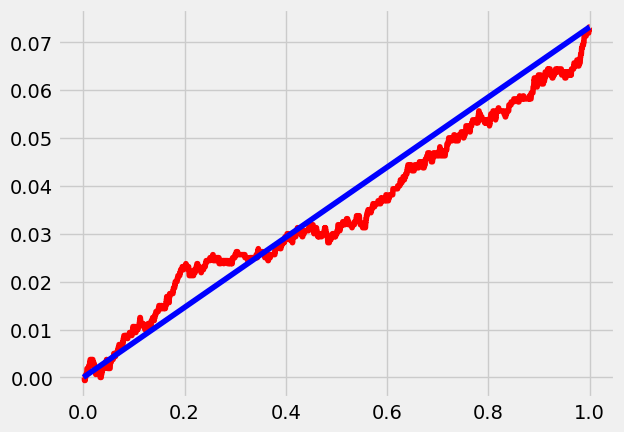

-5.49193

In [55]:
# оцените Qini Score для обученного классификатора

qini_df(df_test)

Кажется, что качество модели опять ухудшилось! Вот так сюрприз! Причина та же самая — размер выборки. К сожалению, X-learner и R-learner дают ощутимый рост качества только на задачах с большим объёмом данных.

# Uplift-деревья

Uplift-деревья — это деревья решений, адаптированные под задачу uplift-моделирования. Они помогают визуализировать и интерпретировать влияние различных факторов на разницу в реакции на целевое воздействие.

Uplift-деревья модифицируют традиционный алгоритм дерева решений, чтобы  оптимизировать uplift, — вместо решения задачи классификации или регрессии. Ключевое различие кроется в функции разделения, которое используется в каждом узле дерева. Вместо использования стандартных критериев, таких как энтропия или Gini Impurity (подробнее об этом можно почитать в статье), uplift-деревья используют критерии, которые измеряют разницу в распределениях uplift между контрольной и экспериментальной группами. 

Цель: найти такие разделения, которые максимизируют разницу между контрольной и экспериментальной группами, тем самым выявляя подгруппы, где воздействие на объекты имеет наибольший эффект.

In [61]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("datasets/discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()
 
discount['old_target'] = (discount['target_class'] % 2 == 0).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

# разобъём нашу выборку на тестовую и валидационную
df_train, df_test = train_test_split(discount, stratify=discount[[treatment_col, target_col]], random_state=1, test_size=0.25)
df_train.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
309,10,95.49,0,1,1,1,1,0,0,0,0,1,0.385971,0.033124,0.501814,0.079090,0.114224,2,1
5927,6,293.78,1,1,1,0,0,1,0,0,0,1,0.522508,0.060261,0.311440,0.105791,0.300301,1,0
8778,6,29.99,0,1,1,0,0,1,0,0,0,1,0.453994,0.041645,0.437831,0.066529,0.095770,0,1
11331,5,467.42,1,1,0,0,0,0,1,0,1,0,0.405045,0.134821,0.225336,0.234798,0.521099,0,1
4924,2,326.64,1,0,0,1,0,0,1,0,1,0,0.514283,0.047125,0.370299,0.068294,0.143541,3,0


## Задание
Выполните базовый код, который загружает данные и строит нужные объекты.

Дополните код, чтобы построить uplift-дерево и оценить, насколько хорошо оно работает на наших данных. Не меняйте параметры в `UpliftTreeClassifier`, чтобы получить верное значение.

При предсказании uplift-эффекта, чтобы получить целевые предсказания, вам потребуется использовать индексацию. Сделать это нужно после функции, вызывающей предсказание модели. Необходимая вам индексация — `[:,1]`.

In [62]:
# !pip install -q duecredit

In [63]:
from causalml.inference.tree import UpliftTreeClassifier

# создадим базовое uplift-дерево
uplift_model = UpliftTreeClassifier(
    max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(
    df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values
)

In [73]:
# предскажите uplift-эффект
uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))[:,1]
df_test['uplift_score'] = uplift_vals

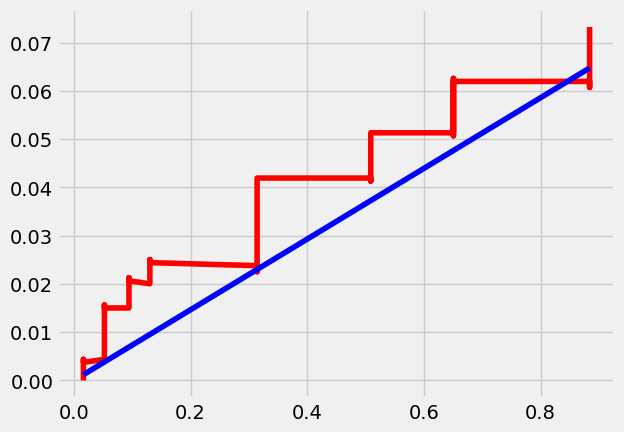

22.393710000000002

In [74]:
# посчитаем метрики 
qini_df(df_test)

Вероятнее всего, что на этой задаче uplift-деревья отработали лучше всего. Почему? Тут есть один очень важный фактор, о котором мы не упоминали ранее, — используемые базовые модели. До этого были линейные модели, а теперь наглядно видно, что нелинейность сильно улучшает качество.